# Import Packages

In [21]:
import numpy as np
import pandas as pd 
import cv2 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential
from PIL import Image

In [22]:
train_folder = 'chest_xray/train'
test_folder = 'chest_xray/test'

In [23]:
labels = ["NORMAL", "PNEUMONIA"] 

# resize image
IMG_SIZE = 256 

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [24]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)

OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/var/folders/qq/w0k1_dh9063ch8xmzxrwjg340000gn/T/ipykernel_39720/881923197.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


/Users/jscheufe/Desktop/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

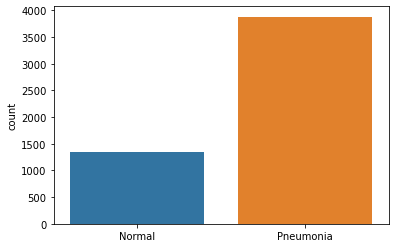

In [25]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")
        
sns.countplot(l)

In [26]:
X_train = []
y_train = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# Noramalize

In [27]:
X_train = np.array(X_train) / 255.0
X_test = np.array(X_test) / 255.0

In [28]:
X_test.shape

(624, 256, 256)

# Reshape

In [29]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Model Training

In [32]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[callback])
scores = model.evaluate(X_test, y_test)

model.save("cnn_model.bin")

Epoch 1/50
110/110 [==============================] - 313s 3s/step - loss: 0.4904 - accuracy: 0.7743 - val_loss: 0.5703 - val_accuracy: 0.7389
Epoch 2/50
110/110 [==============================] - 309s 3s/step - loss: 0.3041 - accuracy: 0.8830 - val_loss: 0.4759 - val_accuracy: 0.8969
Epoch 3/50
110/110 [==============================] - 302s 3s/step - loss: 0.2152 - accuracy: 0.9184 - val_loss: 0.3892 - val_accuracy: 0.9120
Epoch 4/50
110/110 [==============================] - 390s 4s/step - loss: 0.1751 - accuracy: 0.9295 - val_loss: 0.3364 - val_accuracy: 0.9114
Epoch 5/50
110/110 [==============================] - 299s 3s/step - loss: 0.1664 - accuracy: 0.9358 - val_loss: 0.3282 - val_accuracy: 0.9253
Epoch 6/50
110/110 [==============================] - 301s 3s/step - loss: 0.1425 - accuracy: 0.9486 - val_loss: 0.3014 - val_accuracy: 0.9317
Epoch 7/50
110/110 [==============================] - 300s 3s/step - loss: 0.1369 - accuracy: 0.9475 - val_loss: 0.3175 - val_accuracy: 0.9218

INFO:tensorflow:Assets written to: cnn_model.bin/assets


INFO:tensorflow:Assets written to: cnn_model.bin/assets


# Evaluation

In [33]:
print("Test loss {}".format(scores[0]))
print("Test accuracy {}".format(scores[1]))

Test loss 0.5136862397193909
Test accuracy 0.7323718070983887


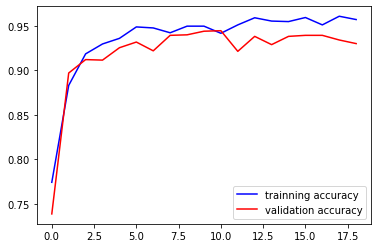

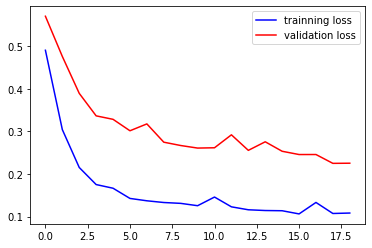

In [34]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [55]:
prediction = model.predict(X_test) 
prediction[:15]

20/20 [==============================] - 16s 805ms/step


array([[0.6264642 ],
       [0.22692832],
       [0.5031447 ],
       [0.5104077 ],
       [0.93623334],
       [0.59360707],
       [0.41981283],
       [0.54494756],
       [0.7715268 ],
       [0.3040676 ],
       [0.72501427],
       [0.72483677],
       [0.16107036],
       [0.25881165],
       [0.38995466]], dtype=float32)

In [80]:
preds = pd.DataFrame(prediction).reset_index()
preds = preds.rename(columns={0:'pred'})
preds['binary_pred'] = np.where(preds['pred'] > 0.5, 1, 0)
preds['true'] = y_test
preds

,index,pred,binary_pred,true
0,0,0.626464,1,0
1,1,0.226928,0,0
2,2,0.503145,1,0
3,3,0.510408,1,0
4,4,0.936233,1,0
...,...,...,...,...
619,619,0.978642,1,1
620,620,0.978889,1,1
621,621,0.978620,1,1
622,622,0.953505,1,1


In [117]:
correct = preds[preds['binary_pred'] == preds['true']]
incorrect = preds[preds['binary_pred'] != preds['true']]

correct_pneumonia = correct[correct['true'] == 1]
correct_normal = correct[correct['true'] == 0]

incorrect_pneumonia = incorrect[incorrect['true'] == 1]
incorrect_normal = incorrect[incorrect['true'] == 0]

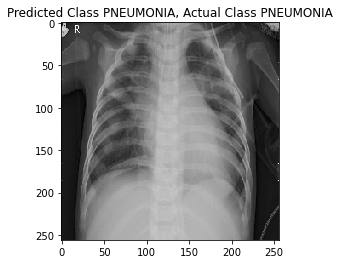

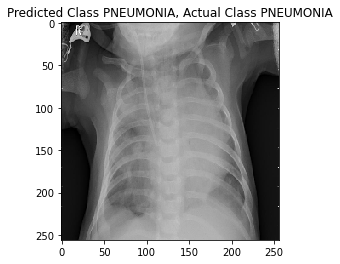

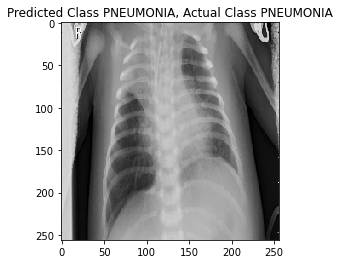

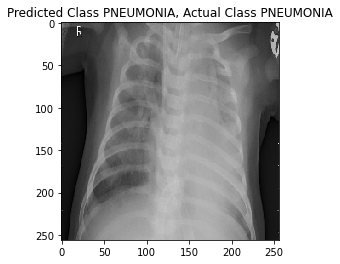

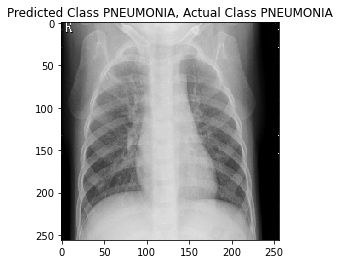

In [118]:
df = correct_pneumonia
for i in pd.Series(range(0,5)):
    label = 'PNEUMONIA'
    if df['true'].iloc[i] == 0:
        label = 'NORMAL'
    plt.imshow(X_test[df['index'].iloc[i]].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(label, label))
    plt.show()
    j += 1

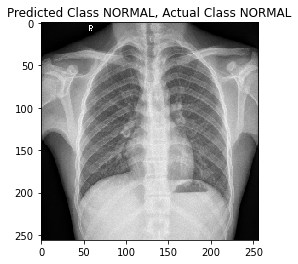

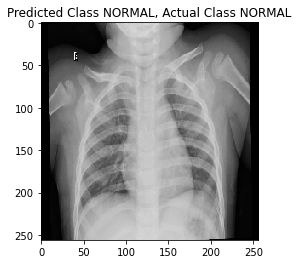

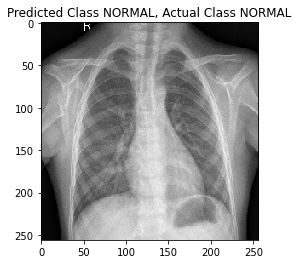

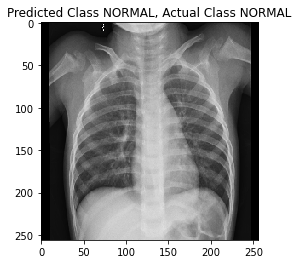

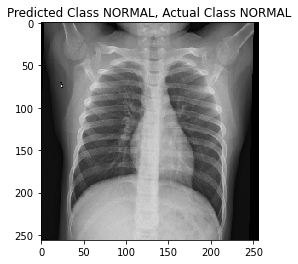

In [119]:
df = correct_normal
for i in pd.Series(range(0,5)):
    label = 'PNEUMONIA'
    if df['true'].iloc[i] == 0:
        label = 'NORMAL'
    plt.imshow(X_test[df['index'].iloc[i]].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(label, label))
    plt.show()
    j += 1

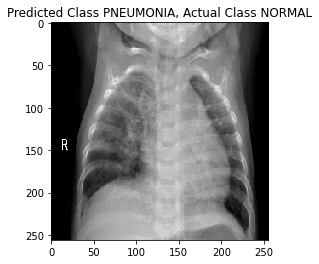

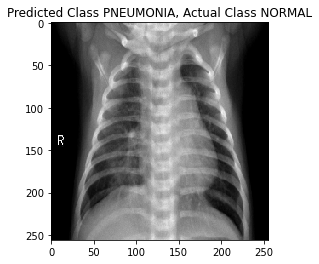

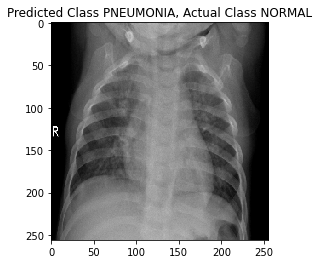

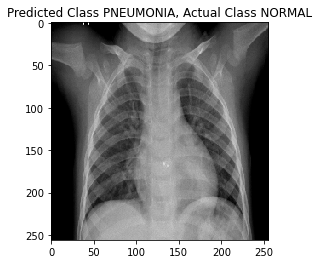

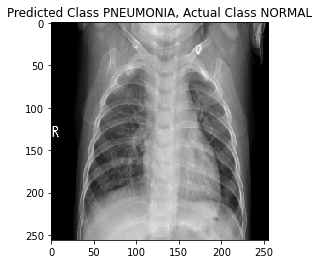

In [121]:
df = incorrect_pneumonia
for i in pd.Series(range(0,5)):
    true_label = 'PNEUMONIA'
    pred_label = 'NORMAL'
    if df['true'].iloc[i] == 0:
        true_label = 'NORMAL'
        pred_label = 'PNEUMONIA'
    plt.imshow(X_test[df['index'].iloc[i]].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(true_label, pred_label))
    plt.show()
    j += 1

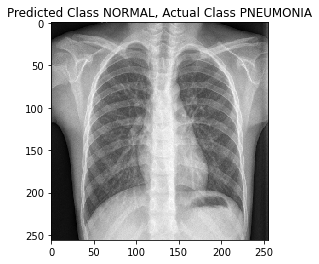

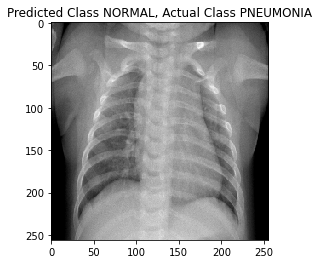

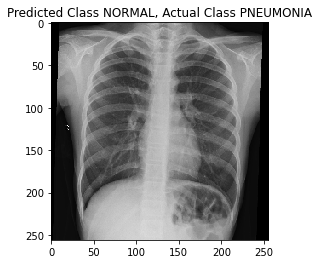

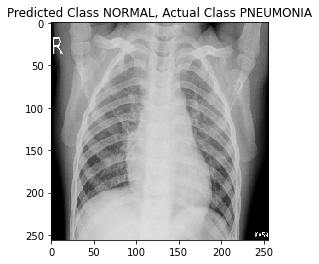

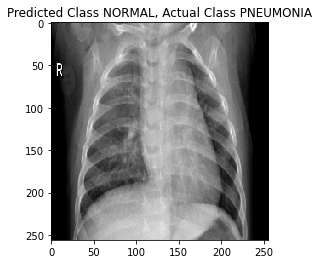

In [122]:
df = incorrect_normal
for i in pd.Series(range(0,5)):
    true_label = 'PNEUMONIA'
    pred_label = 'NORMAL'
    if df['true'].iloc[i] == 0:
        true_label = 'NORMAL'
        pred_label = 'PNEUMONIA'
    plt.imshow(X_test[df['index'].iloc[i]].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(true_label, pred_label))
    plt.show()
    j += 1

# Deployment

In [127]:
labels = ["NORMAL", "PNEUMONIA"]

def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cnn_model.bin") 

In [124]:
# extra pneumonia photo from google
prediction = model.predict([prepare("google_pneumonia_xray_image.png")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 143ms/step
PNEUMONIA


In [132]:
# extra normal x-ray photo from google
prediction = model.predict([prepare("google_normal_xray_image2.png")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 54ms/step
NORMAL
